This is an inference Notebook using [**joeddav/xlm-roberta-large-xnli**](https://huggingface.co/joeddav/xlm-roberta-large-xnli) pre-trained model.<br>
<br>
**About Model:**<br>
This model was fine-tune on [XNLI](https://arxiv.org/pdf/1809.05053.pdf) dataset which contains 15 different languages and its base model [**xlm-roberta-large**](https://huggingface.co/xlm-roberta-large) was trained on 100 different languages. Which mention in this [paper](https://arxiv.org/pdf/1911.02116.pdf)

Install transformers library

In [ ]:
!pip install transformers

Import libraries and download xlm-robrta-large-xnli model.

In [ ]:
import random
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import BatchSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("joeddav/xlm-roberta-large-xnli", padding=True)
model = AutoModelForSequenceClassification.from_pretrained("joeddav/xlm-roberta-large-xnli").to(device)
model.config

Loading data....

In [ ]:
train_data = pd.read_csv('../input/contradictory-my-dear-watson/train.csv', encoding='utf8')
test_data = pd.read_csv('../input/contradictory-my-dear-watson/test.csv', encoding='utf8')
train_data.head()

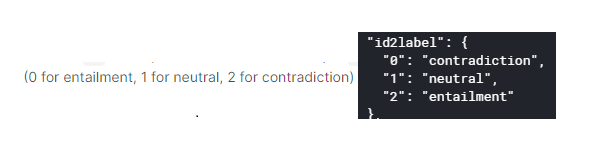<br>
Left side image taken from competition data describe part and right side image taken from model.config output which you can see in model loading code cell output. Hopefully you catch it already by seeing the picture that entailment and contradiction label ids are swiped. So we need to swipe it in our DataFrame label column too which can be done easily by run following code cell.

In [ ]:
train_data['label'] = train_data['label'].replace([0, 2], [2, 0])
train_data.head()

Create a PyTorch Dataset class which will provide us the desire input format for our model.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer, labels = False):
        self.inputs = df.loc[:,['premise', 'hypothesis']].values
        self.tokenizer = tokenizer
        self.labels = labels
        if self.labels:
            self.tgt = df['label'].values
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        inputs = tokenizer(self.inputs[idx].tolist(), add_special_tokens=True, padding=True, return_tensors='pt')
        if self.labels:
            inputs['labels'] = self.tgt[idx]
            return inputs
        return inputs

The model we are using already a fine-tune model. So let us see how it work on our train dataset.

In [ ]:
def eval_model(model, dataloader, device):
    correct = 0
    eval_loss = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        out = model(input_ids=batch['input_ids'].squeeze().to(device),
                    attention_mask=batch['attention_mask'].squeeze().to(device),
                    labels=batch['labels'].squeeze().to(device))
        eval_loss += out[0].item()
        correct += (out[1].argmax(dim=1)==batch['labels'].squeeze().to(device)).float().sum()
    accu = correct / train_dataloader.dataset.__len__()
    eval_loss /= len(dataloader)
    return eval_loss, accu

Choose first 1000 sample for evaluating our model and create PyTorch Dataset, DataLoader object.

In [ ]:
train_dataset = MyDataset(train_data.loc[0:1000], tokenizer, labels=True)
train_dataloader = DataLoader(dataset=train_dataset,
                              sampler=BatchSampler(
                                    SequentialSampler(train_dataset), 
                                    batch_size=8, drop_last=True))
loss, accuracy = eval_model(model, train_dataloader, device)
print("Loss: {}, Accuracy: {}".format(loss, accuracy))

0.935 accuracy is pretty good. Now let us submit our prediction.

In [ ]:
def submission_predict(model, dataloader, device):
    model.eval()
    predicts = np.array([])
    for i, batch in enumerate(dataloader):
        inp_ids = batch['input_ids'].squeeze().to(device)
        mask = batch['attention_mask'].squeeze().to(device)
        out = model(input_ids=inp_ids, attention_mask=mask)
        batch_preds = out[0].argmax(dim=1)
        predicts = np.concatenate((predicts, batch_preds.cpu().detach().numpy()))
    return predicts

In [ ]:
test_dataset = MyDataset(test_data, tokenizer, labels=False)
test_dataloader = DataLoader(dataset=test_dataset,
                              sampler=BatchSampler(
                                    SequentialSampler(test_dataset), 
                                    batch_size=8, drop_last=False), shuffle=False)
test_preds = submission_predict(model, test_dataloader, device)

Remember we swipe our entailment and contradiction ids in train data. We will do the same with our test data predicts.

In [ ]:
submission = np.concatenate((test_data['id'].values.reshape(-1,1), np.int32(test_preds.reshape(-1,1))), axis=1)
submission = pd.DataFrame(submission, columns=['id', 'prediction'])
submission['prediction'] = submission['prediction'].astype(np.int32).replace([0,2], [2,0])
submission.to_csv('submission.csv', index=False)
model.save_pretrained('./model.pt')
tokenizer.save_pretrained('../tokenizer')

In [ ]:
submission